In [3]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, Image

In [88]:
K = np.array([
  [0.000000,0.000000,8.869420,0.000000,0.000000,0.000000,0.000000,0.000000,2.888877,0.000000,0.000000,0.000000],
  [0.001303,-0.026070,0.000000,0.112161,0.005608,0.000360,0.000957,-0.019132,0.000000,0.008356,0.000418,0.000360],
  [0.026070,-0.001303,0.000000,0.005608,0.112161,0.000900,0.019132,-0.000957,0.000000,0.000418,0.008356,0.000900],
  [0.002827,-0.001131,0.000000,0.004865,0.012162,0.014643,0.002075,-0.000830,0.000000,0.000362,0.000906,0.014657],
])

In [260]:
import logging
import time
import numpy as np

import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

URI = f'radio://0/1/2M'

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)

log_keys = ['z',
            'y',
            'roll',
            'pitch',]

other_log_keys = []

if __name__ == '__main__':
    cflib.crtp.init_drivers(enable_debug_driver=False)

    with SyncCrazyflie(URI, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf

        lg_stab = LogConfig(name='LQR', period_in_ms=10)
        lg_data = {}

        for key in log_keys:
            lg_stab.add_variable('stateEstimate.' + key, 'float')
            lg_data[key] = []

        for key in other_log_keys:
            lg_stab.add_variable( key, 'float')
            lg_data[key.split('.')[1]] = []

        # for i in range(4):
        #     for j in range(12):
        #         cf.param.set_value(f'ctrlLQR.k{i + 1}{j + 1}', '{:.6f}'.format(K[i, j]))
        # cf.param.set_value(f'ctrlLQR.k{0 + 1}{2 + 1}', '{:.6f}'.format(K[0, 2]))

        cf.param.set_value('kalman.resetEstimation', '1')  # will reset all states
        time.sleep(0.1)
        cf.param.set_value('kalman.resetEstimation', '0')
        time.sleep(2)
        print('Reset Kalman filter.')
            
        print('Switching to LQR!')
        cf.param.set_value('stabilizer.controller', '5')
        time.sleep(0.1)
        for y in range(10):
            cf.commander.send_position_setpoint(0, 0, y / 25, 0)
            time.sleep(0.1)
        cf.param.set_value('stabilizer.controller', '5')  # re-initialize after each (unresetted) run
        time.sleep(0.1)
        print('Taking off!')

        # cf.param.set_value('stabilizer.controller', '5')
        with SyncLogger(scf, lg_stab) as logger:
            t_start = time.time()
            entry_count = 0

            for log_entry in logger:
                delta_t = time.time() - t_start

                cf.commander.send_position_setpoint(0, 0, 0.5, 0)
                for key, value in log_entry[1].items():
                    lg_data[key.split('.')[1]].append(value)

                entry_count += 1

                if delta_t > 5:  # x100 data points
                    break

        print('Saving data...')
        for key in lg_data.keys():
            lg_data[key] = np.array(lg_data[key])

        np.savez('quad_data/quad_traj', **lg_data)

        for y in range(10):
            cf.commander.send_position_setpoint(0, 0, (10 - y) / 25, 0)
            time.sleep(0.15)

        for i in range(10):
            cf.commander.send_stop_setpoint()
            time.sleep(0.1)

print('Done!') 

Reset Kalman filter.
Switching to LQR!
Taking off!
Saving data...
Done!


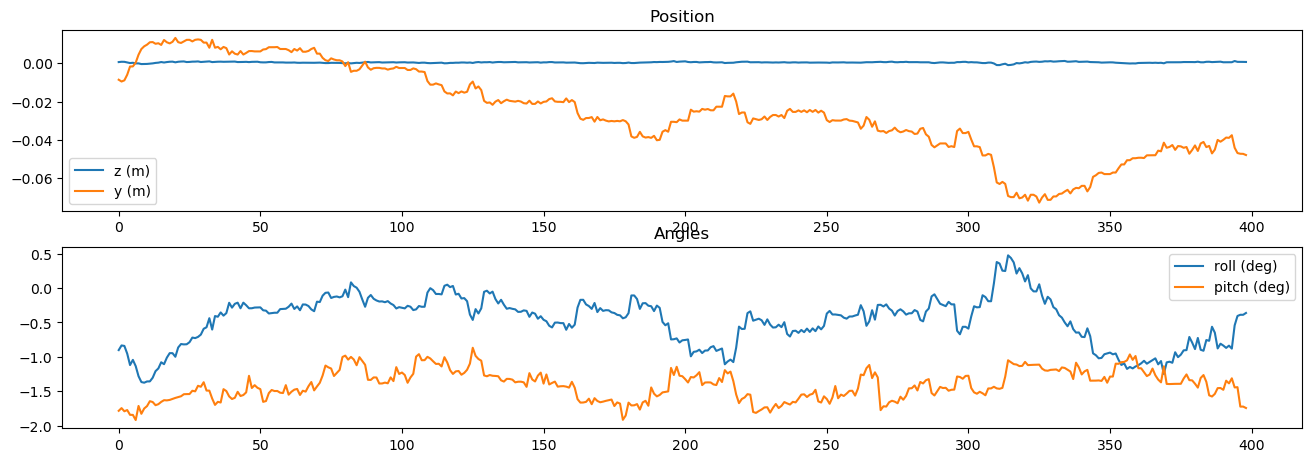

In [262]:
import os

if os.path.isfile('quad_data/quad_traj.npz'):
    npzfile = np.load('quad_data/quad_traj.npz')

    plt.rcParams["figure.figsize"] = (16,8)
    fig = plt.figure()

    ax = fig.add_subplot(311, title='Position')
    ax.plot(npzfile['z'][:400], label='z (m)')
    ax.plot(npzfile['y'][:400], label='y (m)')
    ax.legend()

    ax = fig.add_subplot(312, title='Angles')
    ax.plot(npzfile['roll'][:400], label='roll (deg)')
    ax.plot(npzfile['pitch'][:400], label='pitch (deg)')
    ax.legend()

    # ax = fig.add_subplot(313, title='Moments')
    # ax.plot(npzfile['u2_pwm'][:125] / (2 ** 15), label='M1')
    # ax.plot(npzfile['u3_pwm'][:125] / (2 ** 15), label='M2')
    # ax.legend()
else:
    print('No flight data found.')